In [ ]:
# 필요한 모듈 import

import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# 구글 드라이브 연동

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 데이터 전처리

In [ ]:
def list_dataset():
    for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/데기인/team project/dataset'):
        for filename in filenames:
            print(os.path.join(dirname, filename))


# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]

In [ ]:
IMAGES_DIR = '/content/drive/MyDrive/Colab Notebooks/데기인/team project/dataset/'

train_file = '/content/drive/MyDrive/Colab Notebooks/데기인/team project/one-indexed-files-notrash_train.txt'
val_file   = '/content/drive/MyDrive/Colab Notebooks/데기인/team project/one-indexed-files-notrash_val.txt'
test_file  = '/content/drive/MyDrive/Colab Notebooks/데기인/team project/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(test_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 431 samples.


In [ ]:
df_test.head()

,rel_path,label
0,paper/paper70.jpg,paper
1,paper/paper380.jpg,paper
2,cardboard/cardboard31.jpg,cardboard
3,glass/glass12.jpg,glass
4,paper/paper169.jpg,paper


In [ ]:
datagen = ImageDataGenerator()

datagen_train = datagen.flow_from_dataframe(

    ###  Augmentation Start  ###

    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,

    ##  Augmentation End  ###

    target_size=(224,224),
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    rescale=1/255.,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    target_size=(224,224),
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    rescale=1/255.,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_test = datagen.flow_from_dataframe(
    target_size=(224,224),
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    rescale=1./255,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 431 validated image filenames belonging to 6 classes.


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 2. resnet 모형 적합

In [ ]:
from tensorflow.keras.applications import ResNet50, DenseNet121, DenseNet201

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)

preds = tf.keras.layers.Dense(6, activation='softmax')(x)

resnet50 = tf.keras.Model(inputs=base_model.input, outputs=preds)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Compile the model
resnet50.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/Colab Notebooks/데기인/checkpoint/best_cnn_1.ckpt"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,             #모수값만 저장
    monitor='val_accuracy',               #val_loss
    mode='max',                             #min , auto로 해도 됨
    save_best_only=True,                  #최적값만 저장
    verbose=1)                               #얼마나 자세히? 적당히1

# Train the model.
history = resnet50.fit_generator(generator=datagen_train,
          validation_data=datagen_valid,
          epochs=100,                                         #기본 100~200
          verbose=1,
          callbacks=[model_checkpoint_callback]
)

<ipython-input-10-e1f106dc04fb>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet50.fit_generator(generator=datagen_train,


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 1.4427 - accuracy: 0.5345 
Epoch 1: val_accuracy improved from -inf to 0.18598, saving model to /content/drive/MyDrive/Colab Notebooks/데기인/checkpoint/best_cnn_1.ckpt
56/56 [==============================] - 832s 14s/step - loss: 1.4427 - accuracy: 0.5345 - val_loss: 1100.4844 - val_accuracy: 0.1860
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.8638 - accuracy: 0.6872
Epoch 2: val_accuracy improved from 0.18598 to 0.26524, saving model to /content/drive/MyDrive/Colab Notebooks/데기인/checkpoint/best_cnn_1.ckpt
56/56 [==============================] - 22s 393ms/step - loss: 0.8638 - accuracy: 0.6872 - val_loss: 6.0275 - val_accuracy: 0.2652
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.7245
Epoch 3: val_accuracy improved from 0.26524 to 0.44512, saving model to /content/drive/MyDrive/Colab Notebooks/데기인/checkpoint/best_cnn_1.ckpt
56/56 [=========

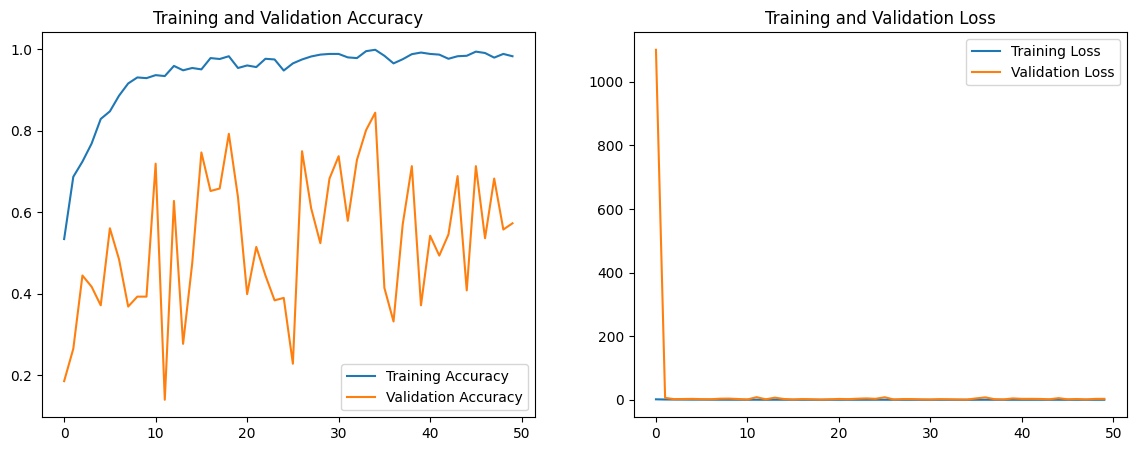

In [ ]:
# accuracy, loss 그래프

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# 최적의 성능을 갖는 모형 로드하기
# 불러온 모형의 성능 확인
resnet50.load_weights(checkpoint_filepath)
score=resnet50.evaluate(datagen_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

431/431 [==============================] - 188s 435ms/step - loss: 0.7457 - accuracy: 0.8353
Test loss: 0.7457270622253418
Test accuracy: 0.8352668285369873


431/431 [==============================] - 7s 12ms/step
Classification Report
              precision    recall  f1-score   support

   cardboard       0.97      0.87      0.92        70
       glass       0.82      0.87      0.84        82
       metal       0.85      0.78      0.82        68
       paper       0.89      0.90      0.89       108
     plastic       0.67      0.86      0.76        74
       trash       0.93      0.48      0.64        29

    accuracy                           0.84       431
   macro avg       0.86      0.79      0.81       431
weighted avg       0.85      0.84      0.83       431



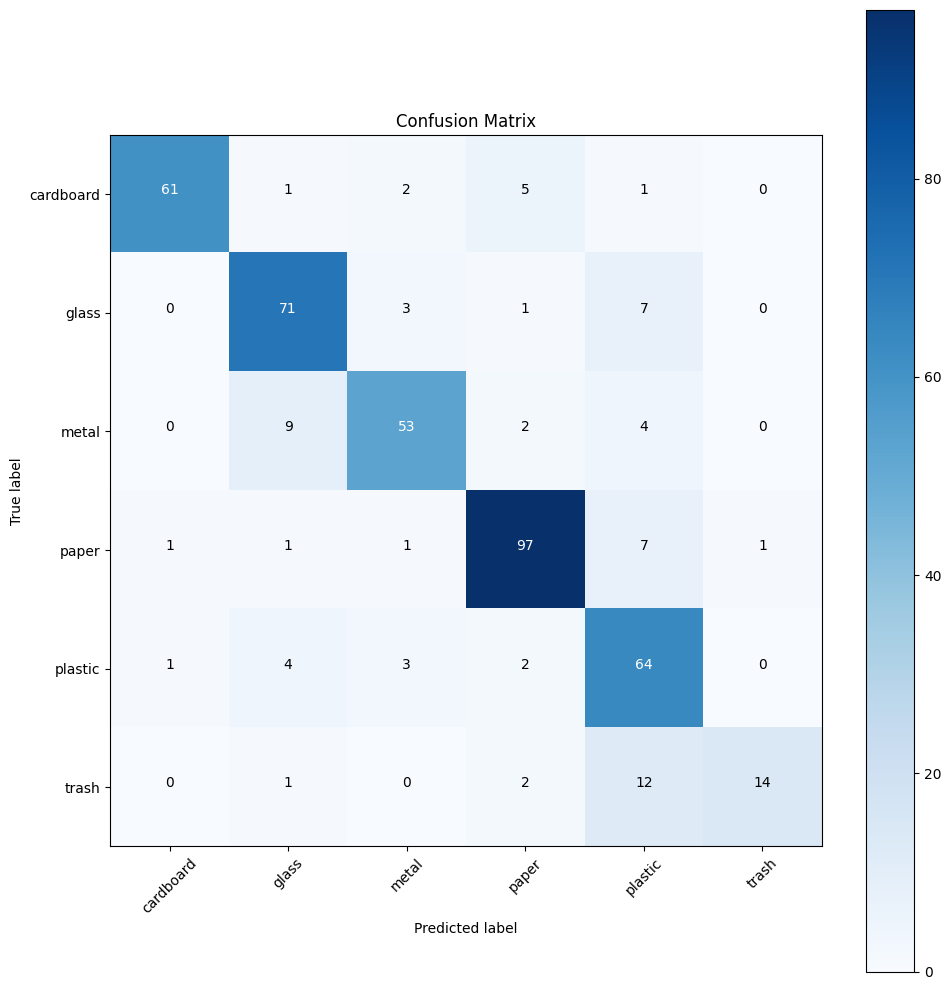

In [ ]:
Y_pred = resnet50.predict(datagen_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Confusion Matrix
cm = confusion_matrix(datagen_test.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(datagen_test.classes, y_pred, target_names=target_names))